# How to propagate fields in `meow`
> a brief introduction to `propagate_modes`

In [ ]:
import gdsfactory as gf
import meow as mw
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["pcolor.shading"]="auto"

2023-11-14 08:56:39.030 | INFO     | gdsfactory.config:__init__:205 - LogLevel: INFO


In [ ]:
try:
    import klujax
except:
    import warnings
    warnings.warn("Klujax could not be loaded falling back to default backend for sax, which is going to be slow")

In [ ]:
def example_extrusions(
    t_slab: float = 0.0,
    t_soi: float = 0.4,
    t_ox: float = 0.0,
):
    """ create some simple extrusion rules
    
    Args:
        t_slab: the slab thickness
        t_soi: the SOI thickness
        t_ox: the oxide layer thickness
    """
    extrusions = {
        (1, 0): [
            mw.GdsExtrusionRule(
                material=mw.silicon,
                h_min=0.0,
                h_max=0.0 + t_soi,
                mesh_order=1,
            ),
        ],
    }
    return extrusions

In [ ]:
l_taper=10
l_center=20
w_center=3

mmi = gf.components.mmi2x2(length_taper=l_taper, 
   length_mmi=l_center, 
   width_mmi=w_center)

c = gf.Component()
ref = c.add_ref(mmi)
ref.xmin = 0
mmi = c

extrusion_rules = example_extrusions()
structs = mw.extrude_gds(mmi, extrusion_rules)

#mw.visualize(structs, scale=(1, 1, 0.2))

In [ ]:
mmi.plot()

You can install `pip install gdsfactory[cad]` for better visualization


/home/jd/work/side/skill-challenge/.venv/lib/python3.10/site-packages/gdsfactory/component.py:1538: UserWarning: Component 'Unnamed_eee44b9e' contains 1 Unnamed cells
  gdspath = component.write_gds(logging=False)


Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15'\x…

In [ ]:
eps = 1e-10
w_sim = w_center + 2
h_sim = 2.0
mesh = 100
num_cells = 10
Ls = [l_taper / num_cells]*num_cells
Ls[-1] -= eps
Ls[0] -= eps
Ls += [2*eps, l_center-2*eps, 2*eps] + Ls
Ls = [eps] + Ls + [eps]
print(Ls)

cells = mw.create_cells(
    structures=structs,  
    mesh=mw.Mesh2d(
        x=np.linspace(-w_sim/2, w_sim/2, mesh + 1),
        y=np.linspace(-h_sim/2, h_sim/2, mesh + 1),
    ),
    Ls=Ls
)

#for cell in cells:
# mw.visualize(cell)

[1e-10, 0.9999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999, 2e-10, 19.9999999998, 2e-10, 0.9999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999, 1e-10]


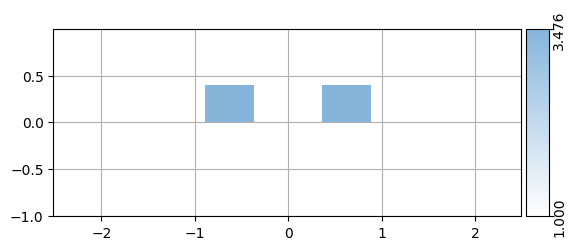

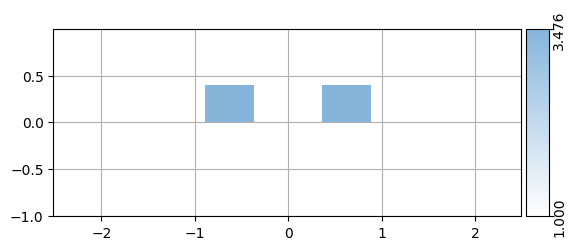

In [ ]:
env = mw.Environment(wl=1.55, T=25.0)
css = [mw.CrossSection(cell=cell, env=env) for cell in cells]

mw.visualize(css[0])
mw.visualize(css[-1])

In [ ]:
num_modes=10

In [ ]:
from tqdm.notebook import tqdm
modes = [mw.compute_modes(cs, num_modes=num_modes) for cs in tqdm(css)]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
import pickle
with open(f"../assets/modes.pkl", "wb") as file:
    pickle.dump(modes, file)

In [ ]:
modes[0] = [modes[0][0] + modes[0][1], modes[0][0] - modes[0][1]] 
modes[-1] = [modes[-1][0] + modes[-1][1], modes[-1][0] - modes[-1][1]]

In [ ]:
from meow.mode import is_pml_mode
modes = [[m for m in modes_ if not is_pml_mode(m,0.3)] for modes_ in modes]

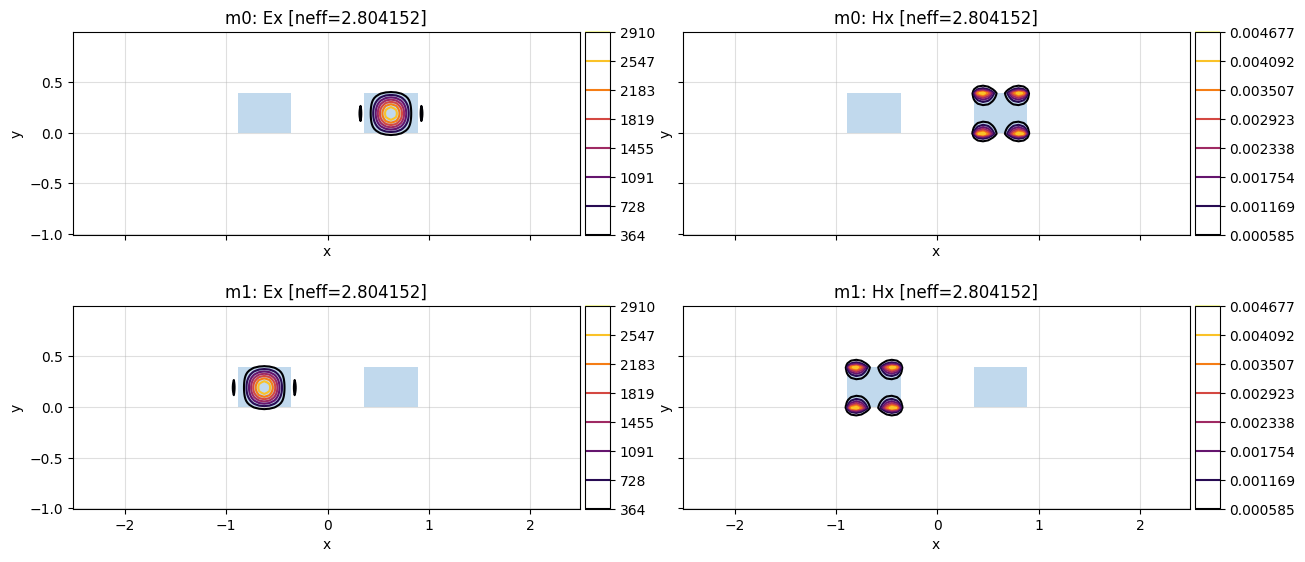

In [ ]:
mw.visualize(modes[0])

{'left@0': 0, 'left@1': 1, 'right@0': 2, 'right@1': 3}


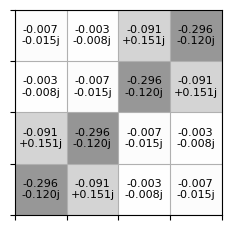

In [ ]:
S, port_map = mw.compute_s_matrix(modes)
print(port_map)
mw.visualize(S)

In [ ]:
from meow.eme.propagate import propagate_modes

<matplotlib.collections.QuadMesh>

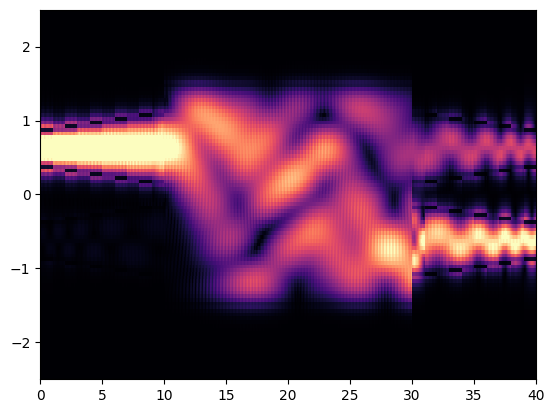

In [ ]:
z = np.linspace(0, l_taper*2+l_center, 1000)
E, x = propagate_modes(modes, np.array([1,0]), np.array([0,0]), 0.2, z)
X, Y = np.meshgrid(z, x)
lim = np.quantile(np.abs(E), 0.98)
plt.pcolormesh(X, Y, np.abs(E).T, shading="nearest", cmap="magma", vmin=0, vmax=lim)

<matplotlib.collections.QuadMesh>

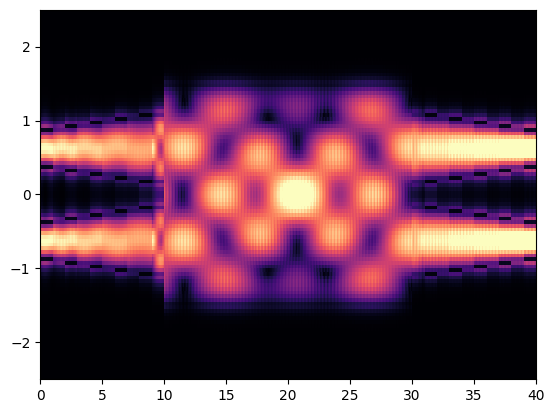

In [ ]:
z = np.linspace(0, l_taper*2+l_center, 1000)
E, x = propagate_modes(modes, np.array([0,0]), np.array([1,1]), 0.2, z)
X, Y = np.meshgrid(z, x)
lim = np.quantile(np.abs(E), 0.98)
plt.pcolormesh(X, Y, np.abs(E).T, shading="nearest", cmap="magma", vmin=0, vmax=lim)